In [7]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import tensorflow_probability as tfp
from sklearn.metrics.pairwise import polynomial_kernel
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
from sklearn.model_selection import train_test_split
import csv


In [10]:
TF_USE_LEGACY_KERAS=1

In [11]:
tf.config.optimizer.set_jit(False)
os.environ['TF_DISABLE_LAYOUT_OPTIMIZATION'] = '1'
os.environ['TF_USE_LEGACY_KERAS'] = '1'



In [12]:
comics_path = "/kaggle/input/comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/comics"
faces_path= "/kaggle/input/comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces"


In [13]:
sample_image_comics = tf.io.read_file(str(comics_path + '/1.jpg'))
sample_image_faces = tf.io.read_file(str(faces_path + '/1.jpg'))

sample_image_comics = tf.io.decode_jpeg(sample_image_comics)
sample_image_faces = tf.io.decode_jpeg(sample_image_faces)

print(sample_image_comics.shape)
print(sample_image_faces.shape)

(1024, 1024, 3)
(1024, 1024, 3)


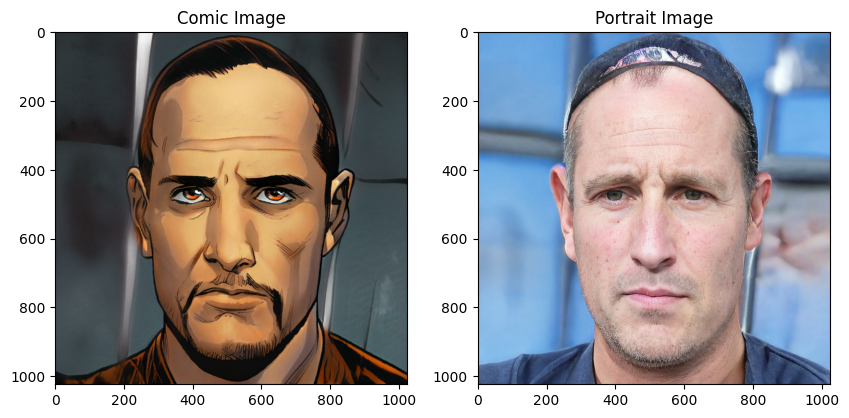

In [14]:
# Tạo một hình ảnh với 1 hàng và 2 cột
plt.figure(figsize=(10, 5))

# Hiển thị ảnh truyện tranh
plt.subplot(1, 2, 1)
plt.imshow(sample_image_comics)
plt.title('Comic Image')

# Hiển thị ảnh chân dung
plt.subplot(1, 2, 2)
plt.imshow(sample_image_faces)
plt.title('Portrait Image')

# Hiển thị hình ảnh
plt.show()

In [15]:
def load(face_image,comic_image):
    image_face = tf.io.read_file(face_image)
    image_face = tf.io.decode_jpeg(image_face)
    image_comic = tf.io.read_file(comic_image)
    image_comic = tf.io.decode_jpeg(image_comic)
    face_image = tf.cast(image_face, tf.float32)
    comic_image = tf.cast(image_comic, tf.float32)
    return face_image,comic_image
def load_one_image(input_image):
    input_image = tf.io.read_file(input_image)
    input_image = tf.io.decode_jpeg(input_image)
    input_image = tf.cast(input_image, tf.float32)
    return input_image

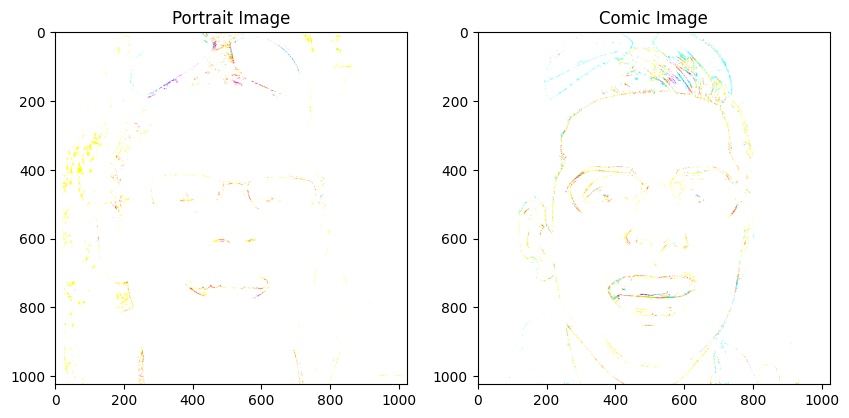

In [16]:
face_image, comic_image = load(str(faces_path +"/3.jpg" ),str(comics_path+"/3.jpg"))
plt.figure(figsize=(10, 5))

# Hiển thị ảnh truyện tranh
plt.subplot(1, 2, 1)
plt.imshow(face_image)
plt.title('Portrait Image')

# Hiển thị ảnh chân dung
plt.subplot(1, 2, 2)
plt.imshow(comic_image)
plt.title('Comic Image')

# Hiển thị hình ảnh
plt.show()

In [17]:
# The facade training set consist of 400 images
BUFFER_SIZE = 200
OUTPUT_CHANNELS = 3
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256
LAMBDA = 100

In [18]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image
def resize_one_image(input_image,height,width):
    input = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

def normalize_one_image(input_image):
    input_image = (input_image / 127.5) - 1

    return input_image


In [19]:
@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

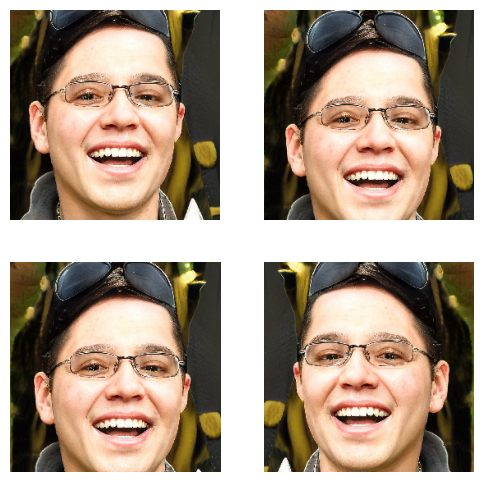

In [20]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(face_image, comic_image)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
plt.show()

In [21]:
def load_image_train(faces_path_file, comics_path_file):
    input_image, real_image = load(faces_path_file, comics_path_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image
def load_image_test(faces_path_file, comics_path_file):
    input_image, real_image = load(faces_path_file, comics_path_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image
def load_one_image_to_predict(input_image):
    input_image = load_one_image(input_image)
    input_image = resize_one_image(input_image, IMG_HEIGHT, IMG_WIDTH)
    input_image = normalize_one_image(input_image)
    return input_image

In [22]:
# Get the complete list of image paths
faces_paths = tf.data.Dataset.list_files(str(faces_path + '/*.jpg'))
comics_paths = tf.data.Dataset.list_files(str(comics_path + '/*.jpg'))
faces_paths_list = [str(path.numpy(), 'utf-8') for path in faces_paths]
comics_paths_list = [str(path.numpy(), 'utf-8') for path in comics_paths]

# Sort by file name
sorted_faces_paths = sorted(faces_paths_list)
sorted_comics_paths = sorted(comics_paths_list)

# Split into training and testing sets
split_ratio = 0.8
num_faces_train = int(len(sorted_faces_paths) * split_ratio)
num_comics_train = int(len(sorted_comics_paths) * split_ratio)

train_faces_paths = sorted_faces_paths[:num_faces_train]
test_faces_paths = sorted_faces_paths[num_faces_train:]

train_comics_paths = sorted_comics_paths[:num_comics_train]
test_comics_paths = sorted_comics_paths[num_comics_train:]

# Create the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_faces_paths, train_comics_paths))
train_dataset = train_dataset.map(lambda x, y: load_image_train(x, y), num_parallel_calls=tf.data.AUTOTUNE)
BUFFER_SIZE = 1000
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

# Create the testing dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_faces_paths, test_comics_paths))
test_dataset = test_dataset.map(lambda x, y: load_image_test(x, y), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [23]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    # Add batch normalization and LeakyReLU if specified
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())

    # Add dropout for regularization if specified
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

# Create models for downsampling and upsampling
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(face_image, 0))
up_model = upsample(3, 4)
up_result = up_model(down_result)


In [24]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  
    downsample(256, 4),  
    downsample(512, 4),  
    downsample(512, 4),  
    downsample(512, 4),  
    downsample(512, 4),  
    downsample(512, 4),  
    ]

    up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  
    upsample(512, 4, apply_dropout=True),  
    upsample(512, 4),  
    upsample(256, 4),  
    upsample(128, 4), 
    upsample(64, 4), 
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

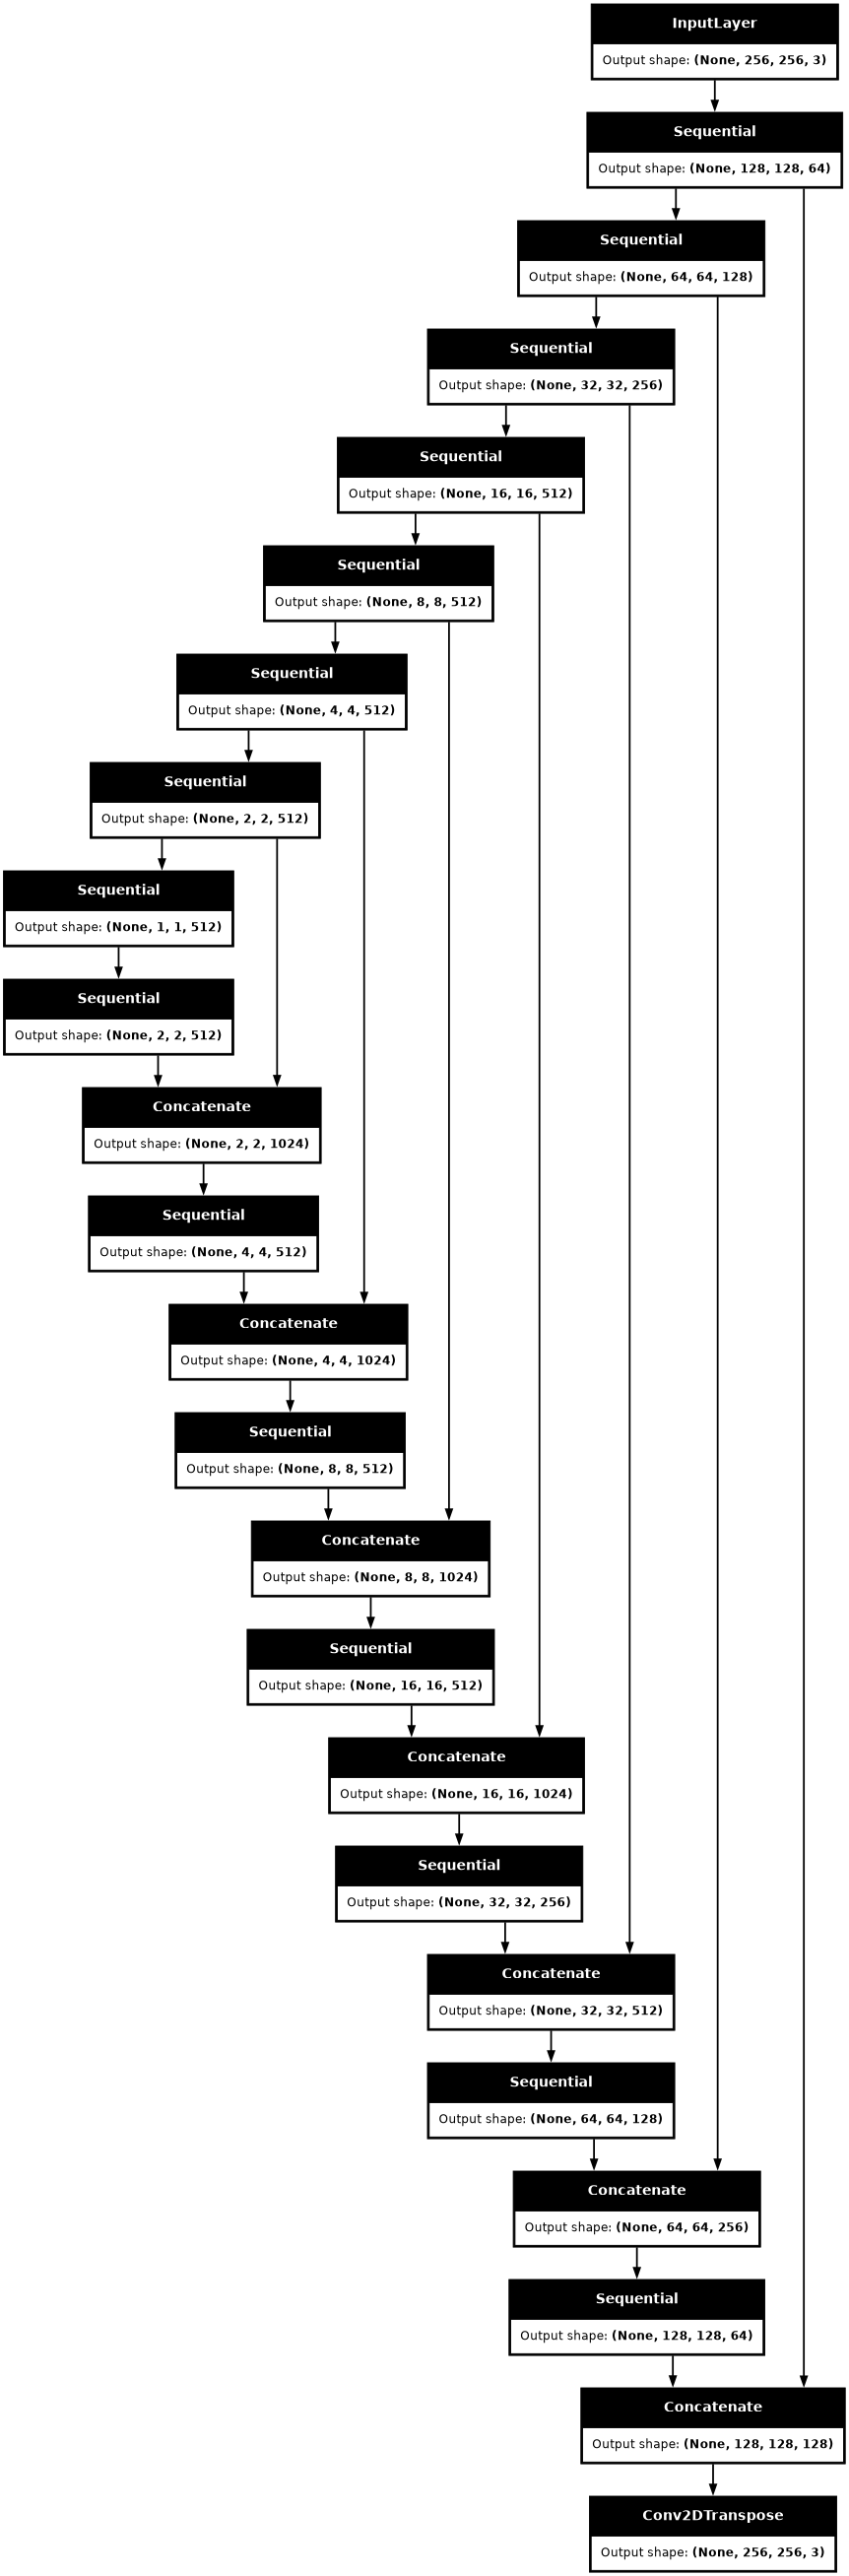

In [25]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

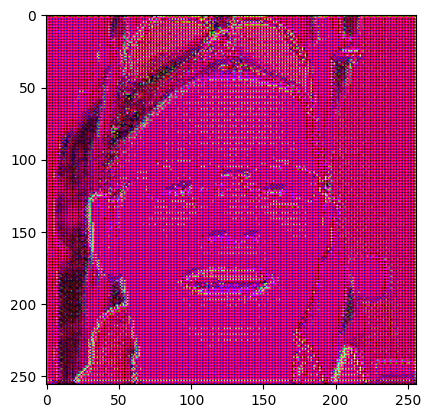

In [26]:
# Resize the face image to 256x256 pixels for the model input
face_image_resized = tf.image.resize(face_image, [256, 256])

# Generate output from the model using the resized image, not training mode
gen_output = generator(face_image_resized[tf.newaxis, ...], training=False)

# Display the generated output image
plt.imshow(gen_output[0, ...])

In [27]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [29]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)  
    down3 = downsample(256, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) 
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) 

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) 

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

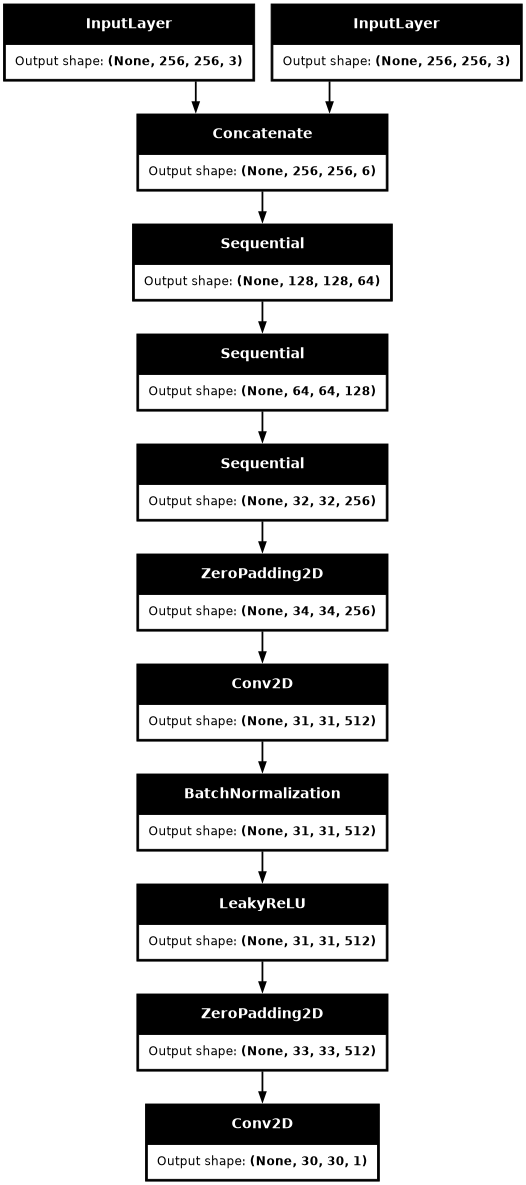

In [30]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

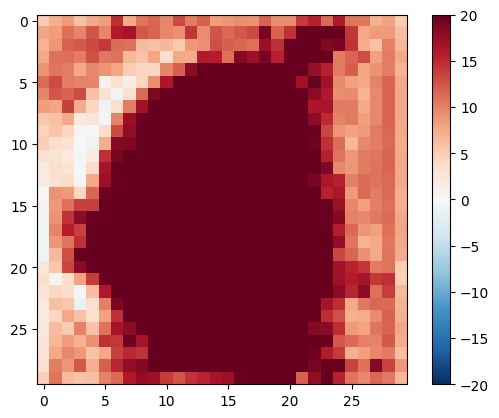

In [31]:
disc_out = discriminator([face_image_resized[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [32]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [34]:
# Define the optimizer for the generator with a set learning rate
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)

# Set the initial learning rate for the optimizer
learning_rate = 2e-4

# Initialize a learning rate schedule for adaptive learning rates
learning_rate_schedule = tf.keras.optimizers.schedules.LearningRateSchedule()

# Define the optimizer for the discriminator using the learning rate schedule
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)


In [35]:
checkpoint_dir = './training_checkpoints'
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=generator,
                                 discriminator=discriminator)

In [36]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()
    
def genneratedImageForGan(model,input):
    predict = model(input,training=True)
    return predict
    
def generate_images_in_real_live(model, test_input):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

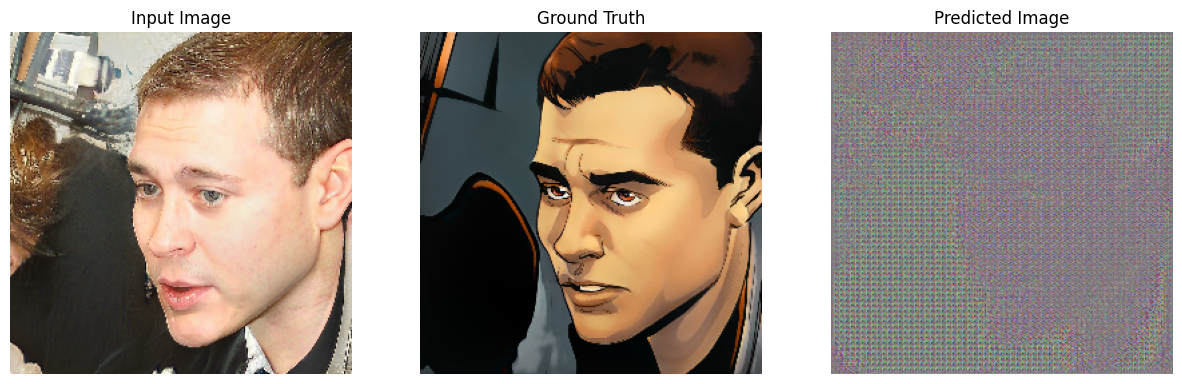

In [37]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [38]:

log_dir="logs/"
summary_writer = tf.summary.create_file_writer(
 log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


In [39]:

def save_model_as_h5(checkpoint_dir,model_filename):
    generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    checkpoint = tf.train.Checkpoint(generator=generator,
                                   discriminator=discriminator)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    generatormodel = tf.keras.Model(inputs=generator.inputs, outputs=generator.outputs)    
    discriminatormodel = tf.keras.Model(inputs=discriminator.inputs, outputs=discriminator.outputs)

    generatormodel.set_weights(generator.get_weights())
    discriminatormodel.set_weights(discriminator.get_weights())
    generatormodel.save(f"{model_filename}_generator.h5")    
    discriminatormodel.save(f"{model_filename}_discriminator.h5")

In [40]:
import tensorflow as tf

@tf.function
def init_csv(step, gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss):
    def write_to_csv(step, gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss):
        import csv
        import os
        
        # Check if the CSV file exists; if not, create it and add a header row
        if not os.path.exists('training_metrics.csv'):
            with open('training_metrics.csv', mode='w') as file:
                writer = csv.writer(file)
                # Write the header row to the CSV file
                writer.writerow(['Step', 'Gen_Total_Loss', 'Gen_GAN_Loss', 'Gen_L1_Loss', 'Disc_Loss'])

        # Open the CSV file in append mode and write the current metrics
        with open('training_metrics.csv', mode='a') as file:
            writer = csv.writer(file)
            # Write the loss metrics to the CSV file
            writer.writerow([step // 1000, gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss])

    # Use TensorFlow's numpy_function to execute the CSV writing operation
    tf.numpy_function(write_to_csv, [step, gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss], [])


In [41]:
def compute_inception_features(images_path):
    # Load Inception model from TensorFlow Hub
    inception_model = hub.load('https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4')
    
    image_list = os.listdir(images_path)
    image_list = [os.path.join(images_path, img) for img in image_list]
    image_data = []
    for img_path in image_list:
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (299, 299)) / 255.0  # Resize image to match Inception input size
        image_data.append(img)
    image_data = tf.stack(image_data)
    features = inception_model(image_data)
    return features


In [42]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        face_image_resized = tf.image.resize(input_image, [256, 256])
        gen_output = generator(face_image_resized, training=True)

        disc_real_output = discriminator([face_image_resized, target], training=True)
        disc_generated_output = discriminator([face_image_resized, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    init_csv(step,gen_total_loss,gen_gan_loss,gen_l1_loss,disc_loss)
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [44]:
import csv
import cv2 as cv
import os
import time
from tqdm import tqdm
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
# from tensorflow.keras.losses import mean_squared_error

def psnr_and_ssim():
    psnr = []
    ssim = []
    
    # Check if groundtruth and predict directories exist
    if not os.path.exists("/kaggle/working/groundtruth") or not os.path.exists("/kaggle/working/predict"):
        print("Groundtruth or predict directory does not exist.")
        return
    
    # Iterate over files in the groundtruth directory
    for i in tqdm(os.listdir('/kaggle/working/groundtruth')):
        fake = cv.imread(os.path.join('/kaggle/working/predict', i))
        real = cv.imread(os.path.join('/kaggle/working/groundtruth', i))
        PSNR = peak_signal_noise_ratio(fake, real)
        psnr.append(PSNR)
        SSIM = structural_similarity(fake, real, win_size=3, multichannel=True, data_range=1)
        ssim.append(SSIM)
    # Calculate average PSNR and SSIM
    average_psnr = np.mean(psnr)
    average_ssim = np.mean(ssim)
    print("The average psnr is", average_psnr)
    print("The average ssim is", average_ssim)

def save_images(fake, real, step):
    # Resize and normalize images before saving
    fake = resize_one_image(fake, 256, 256)    
    real = resize_one_image(real, 256, 256)
    fake = normalize_one_image(fake)
    real = normalize_one_image(real)
    
    # Save processed images in respective directories
    tf.keras.preprocessing.image.save_img(os.path.join('groundtruth/', f'{step}.jpg'),real)
    tf.keras.preprocessing.image.save_img(os.path.join('predict/', f'{step}.jpg'), fake)
    
def resize_input_to_output(input_image, output_image):
    # Check if input and output images have the same dimensions
    if input_image.shape != output_image.shape:
        # Resize input image to match output image dimensions
        input_image = cv.resize(input_image, (output_image.shape[1], output_image.shape[0]))
        
    return input_image


In [45]:
import csv
import shutil
import time
from IPython.display import clear_output

def fit(train_ds, test_ds, steps, csv_filename):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    # Check and remove the groundtruth directory if it exists
    if os.path.exists("groundtruth"):
        shutil.rmtree("groundtruth")
    # Create a new groundtruth directory
    os.makedirs("groundtruth")

    # Check and remove the predict directory if it exists
    if os.path.exists("predict"):
        shutil.rmtree("predict")
    # Create a new predict directory
    os.makedirs("predict")

    # Open a CSV file to record training metrics
    with open(csv_filename, mode='w') as csv_file:
        fieldnames = ['Step']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()

        # Loop through training dataset
        for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
            # Display and save images every 1000 steps
            if (step) % 1000 == 0:
                clear_output(wait=True)
                generated_images = generate_images_for_gan(generator, example_input)
                save_images(generated_images[0], example_target[0], step // 1000)
                start = time.time()
                print(f"Step: {step // 1000}k")

            # Execute a single training step
            train_step(input_image, target, step)

            # Print progress dots every 10 steps
            if (step + 1) % 10 == 0:
                print('.', end='', flush=True)

            # Save model checkpoint every 5000 steps
            if (step + 1) % 5000 == 0:
                checkpoint.save(file_prefix=checkpoint_prefix)
                save_model_as_h5(checkpoint_dir, f"gan_{step // 1000}")
        # Calculate and print PSNR and SSIM metrics
        psnr_and_ssim()


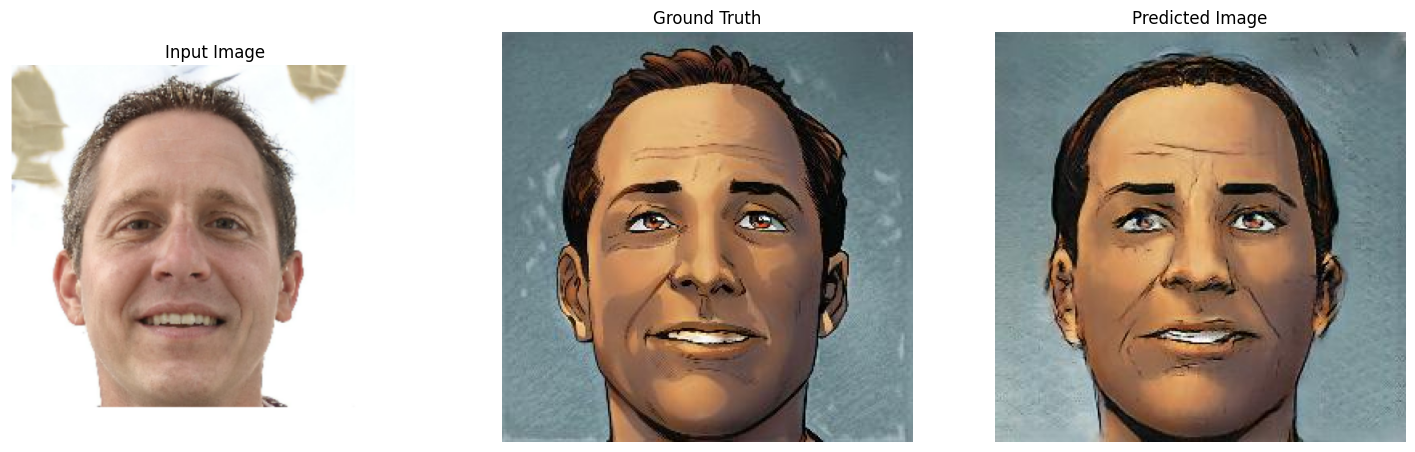

Step: 34k ............................................................................................................................
The average psnr is 18.32634
The average ssim is 0.2783


In [64]:
fit(train_dataset, test_dataset, steps=35000,csv_filename='metrics.csv')

   Step  Gen_Total_Loss  Gen_GAN_Loss  Gen_L1_Loss  Disc_Loss
0     0       55.899868      1.166392     0.547335   1.708547
1     0       54.453335      2.131466     0.523219   3.579652
2     0       49.277220      1.573496     0.477037   3.186661
3     0       46.583424      0.926917     0.456565   1.829087
4     0       43.553100      0.724233     0.428289   1.495665


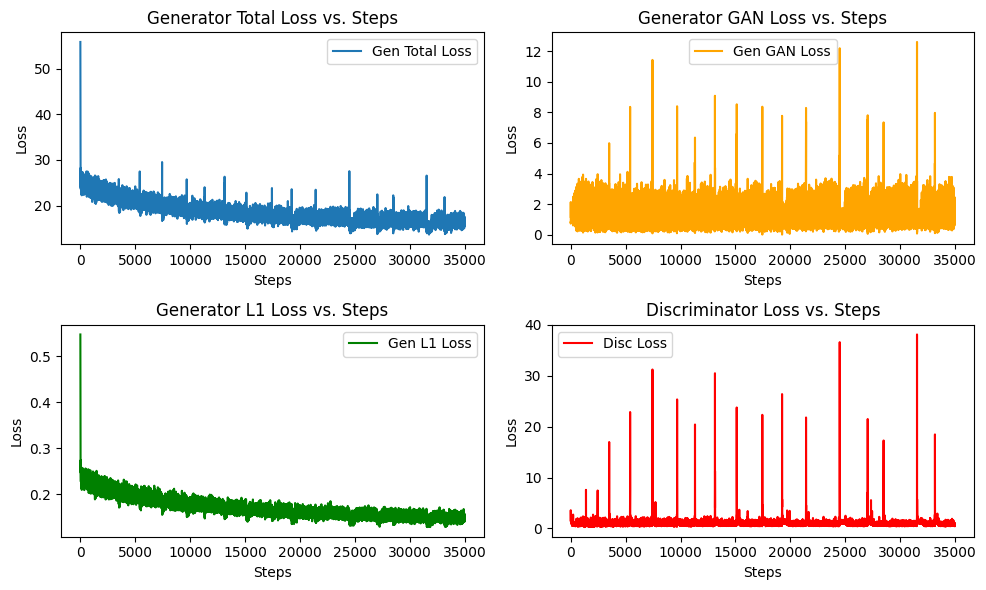

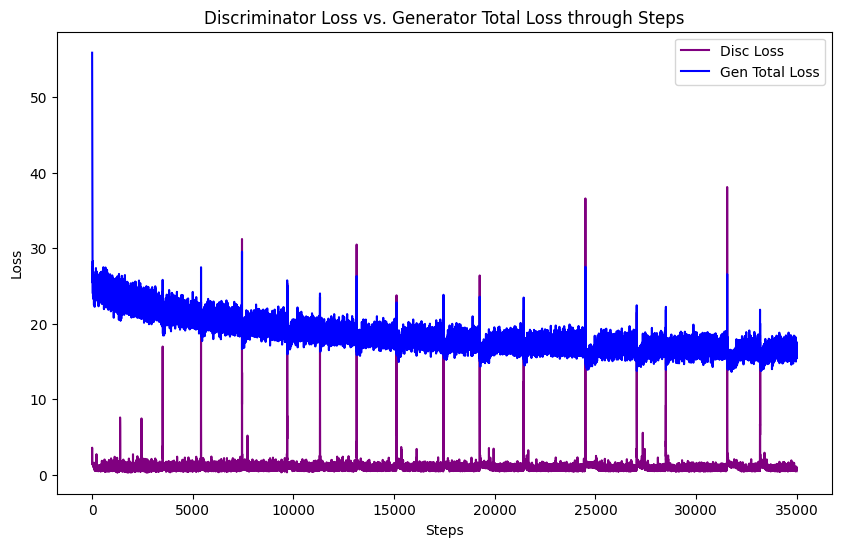

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'your_file.csv' with the actual path to your CSV file
file_path = '/kaggle/input/training-metrics/training_metrics (1).csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

print(df.head())

# Reset the index to create a sequential step column
df.reset_index(inplace=True)

# Extract columns for plotting
steps = df['index']  # Use the new sequential index as steps
gen_total_loss = df['Gen_Total_Loss']
gen_gan_loss = df['Gen_GAN_Loss']
gen_l1_loss = df['Gen_L1_Loss']
disc_loss = df['Disc_Loss']

# Plot Generator Total Loss vs. Steps
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(steps, gen_total_loss, label='Gen Total Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Generator Total Loss vs. Steps')
plt.legend()

# Plot Generator GAN Loss vs. Steps
plt.subplot(2, 2, 2)
plt.plot(steps, gen_gan_loss, color='orange', label='Gen GAN Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Generator GAN Loss vs. Steps')
plt.legend()

# Plot Generator L1 Loss vs. Steps
plt.subplot(2, 2, 3)
plt.plot(steps, gen_l1_loss, color='green', label='Gen L1 Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Generator L1 Loss vs. Steps')
plt.legend()

# Plot Discriminator Loss vs. Steps
plt.subplot(2, 2, 4)
plt.plot(steps, disc_loss, color='red', label='Disc Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Discriminator Loss vs. Steps')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Discriminator Loss vs. Generator Loss (Total) through the steps
plt.figure(figsize=(10, 6))

plt.plot(steps, disc_loss, color='purple', label='Disc Loss')
plt.plot(steps, gen_total_loss, color='blue', label='Gen Total Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Discriminator Loss vs. Generator Total Loss through Steps')
plt.legend()
plt.show()
